Load Data:


We will use torchvision and torch.utils.data packages for loading the data.

The problem we're going to solve today is to train a model to classify cat and dog.

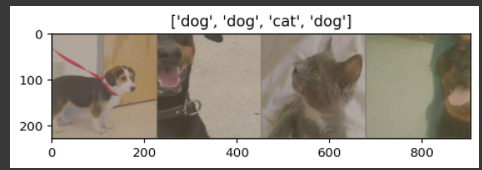

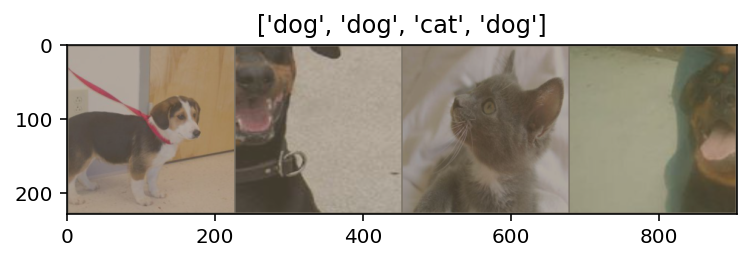

In [8]:
# Imports here
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim, nn
from torchvision import datasets, transforms, models
from collections import OrderedDict
import torchvision
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from PIL import Image
import numpy as np

data_dir = 'drive/MyDrive/big_data/Cat_Dog_data'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
class_names = ["cat", "dog"]

#Define your transforms for the training, validation, and testing sets

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# Load the datasets with ImageFolder

train_data = torchvision.datasets.ImageFolder(train_dir , transform=train_transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=test_transform)

# Using the image datasets and the trainforms, define the dataloaders

trainloader = torch.utils.data.DataLoader(train_data, batch_size = 4, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle = False)

# Load a pre-trained network and reset final fully connected layer
model = models.vgg16(pretrained=True)

# Freeze parameters so we don't backprop through them.
for param in model.parameters():
    param.requires_grad = False

# Use GPU if it's available.   
device= torch.device("cuda" if torch.cuda.is_available() else 'cpu')

model.to(device)
class Classifier(nn.Module):
    # Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

    def __init__(self, input_size, output_size, hidden_layers): # (25088, 102, [1012, 512, 128])
      super().__init__()
      self.input = nn.Linear(input_size, hidden_layers[0])
      self.h2 = nn.Linear(hidden_layers[0], hidden_layers[1])
      self.h3 = nn.Linear(hidden_layers[1], hidden_layers[2])
      self.output = nn.Linear(hidden_layers[-1], output_size)
        # Dropout=20%
      self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):    
      x = x.view(x.shape[0], -1)
      x = self.dropout(F.relu(self.input(x)))
      x = self.dropout(F.relu(self.h2(x)))
      x = self.dropout(F.relu(self.h3(x)))
      x = F.log_softmax(self.output(x),dim=1)

      return x


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 / 5..: Train Loss: 0.209.. test Loss: 0.089... test accuracy: 98.000
Epoch: 2 / 5..: Train Loss: 0.182.. test Loss: 0.064... test accuracy: 97.680
Epoch: 3 / 5..: Train Loss: 0.164.. test Loss: 0.063... test accuracy: 97.480
Epoch: 4 / 5..: Train Loss: 0.162.. test Loss: 0.083... test accuracy: 97.120
Epoch: 5 / 5..: Train Loss: 0.179.. test Loss: 0.058... test accuracy: 98.280


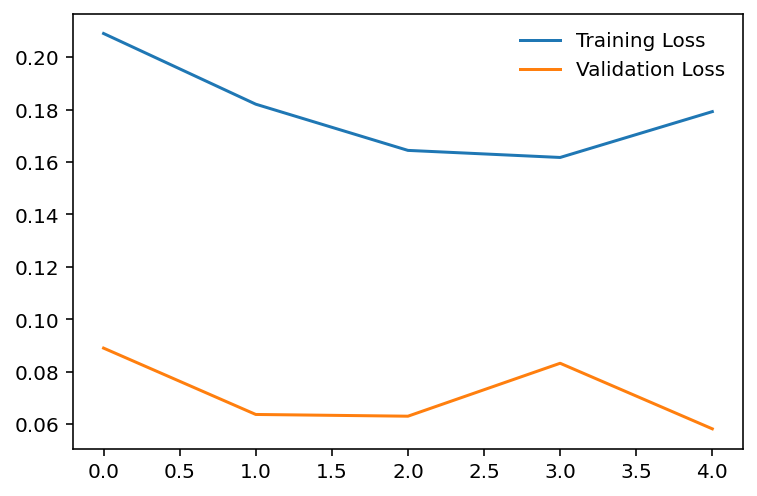

In [ ]:
classifier = Classifier(25088, 102, [1012, 512, 128])
model.classifier = classifier 

# We will use Adam with momentum.
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)
criterion = nn.NLLLoss()

model.to(device)
epochs = 5
train_losses,  test_losses = [], []
for epoch in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        log = model.forward(images)
        loss = criterion(log,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
          model.eval()
          for images, labels in testloader:
              images, labels = images.to(device), labels.to(device)
              log = model.forward(images)
              test_loss += criterion(log, labels)
              ps = torch.exp(log)
              top_p, top_class = ps.topk(1, dim = 1)
              equals = top_class == labels.view(*top_class.shape)
              accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        model.train()
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(testloader))
        print("Epoch: {} / {}..:".format(epoch+1, epochs),
            f"Train Loss: {running_loss / len(trainloader):.3f}..",
              f"test Loss: {test_loss / len(testloader):.3f}...",
              f"test accuracy: {(accuracy / len(testloader))*100:.3f}")


plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(frameon=False);

In [ ]:
def save_check(model):

  model.class_to_idx = train_data.class_to_idx
  checkpoint = {
                "arch" : "vgg16",
                "input_size": 25088,
                "output_size": 102,
                "hidden_layers": [1012, 512, 128],
                "model.class_to_idx": model.class_to_idx,
                "state_dict": model.state_dict()
              }

  torch.save(checkpoint, "checkpoint.pth")
save_check(model)
def load_checkpoint(filepath):

    checkpoint = torch.load(filepath)
    model = Classifier(checkpoint['input_size'],
                    checkpoint['output_size'],
                    checkpoint['hidden_layers'],
                    )
    
    model.load_state_dict(checkpoint["state_dict"], strict=False)
    return model
model = load_checkpoint('checkpoint.pth')
print(model)


Classifier(
  (input): Linear(in_features=25088, out_features=1012, bias=True)
  (h2): Linear(in_features=1012, out_features=512, bias=True)
  (h3): Linear(in_features=512, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=102, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


tensor([[[-0.4397, -0.0629, -0.1143,  ..., -0.5082, -0.6281, -0.6794],
         [-0.4397,  0.0227,  0.0227,  ...,  0.0398, -0.0972, -0.3198],
         [-0.0972,  0.2624,  0.2624,  ...,  0.1768, -0.0116, -0.2856],
         ...,
         [-0.9534, -1.1589, -1.0219,  ..., -0.4739, -0.3883, -0.3712],
         [-0.9363, -1.1247, -1.0390,  ..., -0.3369, -0.2171, -0.1657],
         [-1.5528, -1.3815, -1.0219,  ..., -0.2171, -0.0972, -0.0287]],

        [[ 1.2206,  1.4832,  1.5532,  ...,  1.0105,  0.9230,  0.9230],
         [ 1.1506,  1.5707,  1.7108,  ...,  1.5357,  1.4307,  1.2381],
         [ 1.4657,  1.8333,  1.9734,  ...,  1.6408,  1.4657,  1.2206],
         ...,
         [ 0.1702, -0.0049,  0.2052,  ...,  0.7829,  0.8179,  0.8179],
         [ 0.2577,  0.1877,  0.3627,  ...,  0.8880,  0.9755,  1.0280],
         [-0.2500,  0.1001,  0.5553,  ...,  0.9930,  1.0980,  1.1506]],

        [[ 0.0779,  0.7576,  0.8971,  ...,  0.2871,  0.0431, -0.0615],
         [ 0.1476,  0.8622,  0.9145,  ...,  0

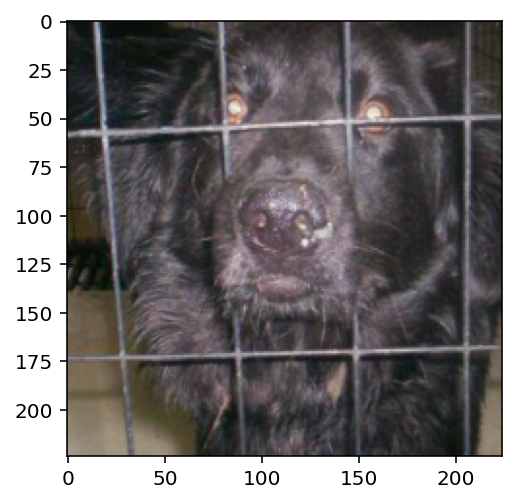

In [ ]:

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    imag = Image.open(image)
    
    transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
    imag_ = transform(imag) 
    return imag_
x = process_image(test_dir+'/dog/dog.10026.jpg')

def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

image = test_dir+'/dog/dog.10059.jpg'
imshow(process_image(image));


In [ ]:
model.to(device)
class Net(nn.Module):# (25088, 102, [1012, 512, 128])
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(21504, 1012)
        self.h2 = nn.Linear(1012, 512)
        self.h3 = nn.Linear(512, 128)
        self.output = nn.Linear(128, 102)
        # Dropout=20%
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):  
      x = x.view(x.shape[0], -1) 
      x = self.dropout(F.relu(self.input(x)))
      x = self.dropout(F.relu(self.h2(x)))
      x = self.dropout(F.relu(self.h3(x)))
      x = F.log_softmax(self.output(x),dim=1)
      
      return x


net = Net()
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

RuntimeError: ignored

In [ ]:









def predict(path_image, model, topk=5):
    
    ''' Predict the class of an image using a trained deep learning model.
    '''
    model.to(device)
    #state_dict = torch.load('checkpoint.pth')
    model.eval()
    with torch.no_grad():
      
      image = process_image(path_image).unsqueeze(dim=0)
      outputs = model.forward(image.to(device))
      ps = torch.exp(outputs)
    probs, indices = ps.topk(topk)
    probs = probs.cpu().data.numpy().argmax()
    #probs = probs.to(device).detach().numpy().tolist()[0]
    #model.idx_to_class = dict(map(reversed, model.class_to_idx.items()))
    model.load_state_dict(state_dict)
    return probs, indices

image_path = test_dir+'/dog/dog.1001.jpg'

predict(image_path, model)

RuntimeError: ignored

In [ ]:
def plot_solution(image_path):
    classes, top_flowers = predict(image_path, model)
    
    plt.figure(figsize=(10,10))
    ax = plt.subplot(2,2,1)
    
    
    img = process_image(image_path)
    imshow(img,ax);

    sb.set_style("whitegrid")
    plt.subplot(2,1,2)
    sb.barplot(x=classes,y=top_flowers, palette = 'Blues')
    plt.xlabel("Probability of Prediction")
    plt.ylabel("")
    plt.show();


image_path = test_dir+'/dog/dog.1001.jpg'

plot_solution(image_path)